# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [3]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   race_url              5281 non-null   object        
 1   race_name             5281 non-null   object        
 2   points                5281 non-null   float64       
 3   uci_points            2780 non-null   float64       
 4   length                5281 non-null   float64       
 5   climb_total           3326 non-null   float64       
 6   profile               3326 non-null   float64       
 7   startlist_quality     5281 non-null   int64         
 8   date                  5281 non-null   datetime64[ns]
 9   mostly_tarmac         5281 non-null   bool          
 10  race_year             5281 non-null   int64         
 11  race_stage            5281 non-null   object        
 12  race_season           5281 non-null   object        
 13  climb_percentage  

In [4]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   cyclist_url                  589739 non-null  object        
 1   cyclist_name                 589739 non-null  object        
 2   birth_year                   589739 non-null  int64         
 3   weight                       480007 non-null  float64       
 4   height                       480007 non-null  float64       
 5   nationality                  589739 non-null  object        
 6   race_url                     589739 non-null  object        
 7   race_name                    589739 non-null  object        
 8   points                       589739 non-null  float64       
 9   uci_points                   422184 non-null  float64       
 10  length                       589739 non-null  float64       
 11  climb_total               

## Anomaly Detection - Cyclists Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 3060 entries, 0 to 6093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  3060 non-null   float64
 1   mean_delta       3060 non-null   float64
 2   mean_position    3060 non-null   float64
 3   birth_year       3060 non-null   int64  
 4   weight           3060 non-null   float64
 5   height           3060 non-null   float64
 6   cyclist_bmi      3060 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 191.2 KB


<Axes: >

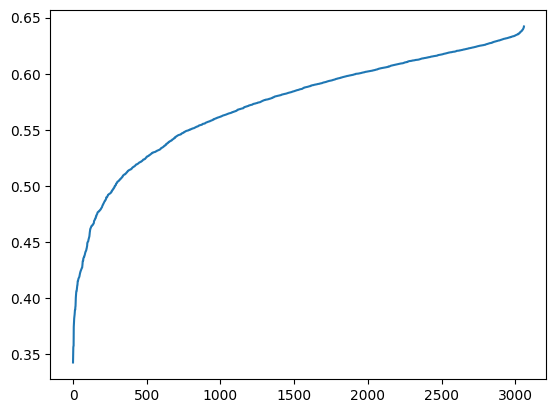

In [5]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [6]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

285

In [7]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.0
mean,0.011411,565.309367,0.554223,1978.884211,69.779298,178.600000,21.789691,0.458075,1.0
std,0.021580,698.875000,0.234275,17.603535,10.836328,10.343127,2.168809,0.034350,0.0
min,0.000002,3.000000,0.044118,1940.000000,48.000000,154.000000,16.412069,0.342800,1.0
25%,0.000288,186.900000,0.377473,1971.000000,61.200000,170.000000,20.098431,0.435757,1.0
50%,0.002285,400.884615,0.539007,1982.000000,69.000000,178.000000,21.719250,0.468260,1.0
75%,0.008456,725.522727,0.722234,1993.000000,79.000000,187.000000,23.334121,0.486019,1.0
max,0.107286,7291.800000,1.000000,2004.000000,94.000000,204.000000,27.770313,0.499918,1.0


In [8]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 2384 entries, 58 to 4927
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2384 non-null   float64
 1   uci_points            2384 non-null   float64
 2   length                2384 non-null   float64
 3   climb_total           2384 non-null   float64
 4   profile               2384 non-null   float64
 5   startlist_quality     2384 non-null   int64  
 6   race_year             2384 non-null   int64  
 7   climb_percentage      2384 non-null   float64
 8   race_physical_effort  2384 non-null   float64
 9   race_prestige         2384 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 204.9 KB


<Axes: >

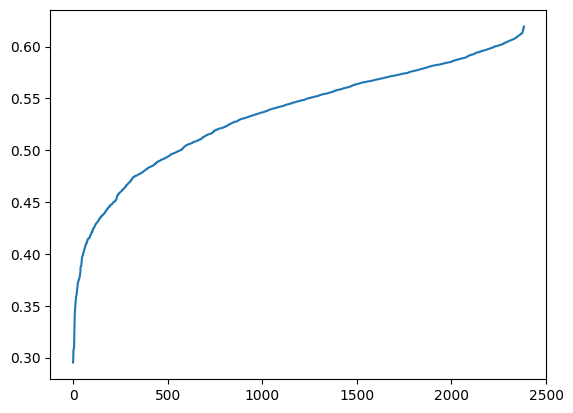

In [9]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [10]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

567

In [11]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,race_year,climb_percentage,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567,567.000000,567.000000,567.000000,567.000000,567.000000,567.0
mean,146.375661,221.093474,164.664727,2.808416,2.945326,1086.550265,2013-10-20 11:13:00.952380928,2013.358025,0.027151,0.212913,0.244448,0.454813,1.0
min,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-03 00:00:00,2001.000000,0.000191,0.000003,0.000000,0.295229,1.0
25%,80.000000,20.000000,109.500000,0.904000,2.000000,796.000000,2008-03-04 12:00:00,2008.000000,0.008715,0.014113,0.102116,0.434288,1.0
50%,100.000000,120.000000,196.000000,2.993000,3.000000,1013.000000,2014-07-26 00:00:00,2014.000000,0.017017,0.170922,0.253017,0.466442,1.0
75%,225.000000,450.000000,231.000000,4.405500,5.000000,1496.000000,2019-07-27 12:00:00,2019.000000,0.026532,0.355508,0.320561,0.485255,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,2023.000000,0.981053,0.910685,0.908128,0.499921,1.0
std,92.340752,212.092678,88.520225,1.845019,1.534817,409.130368,NaN,6.842024,0.064362,0.210438,0.163167,0.040042,0.0


In [12]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 348047 entries, 59 to 589737
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   birth_year                   348047 non-null  int64  
 1   weight                       348047 non-null  float64
 2   height                       348047 non-null  float64
 3   points                       348047 non-null  float64
 4   uci_points                   348047 non-null  float64
 5   length                       348047 non-null  float64
 6   climb_total                  348047 non-null  float64
 7   profile                      348047 non-null  float64
 8   startlist_quality            348047 non-null  int64  
 9   position                     348047 non-null  float64
 10  cyclist_age                  348047 non-null  int64  
 11  delta                        348047 non-null  float64
 12  race_year                    348047 non-null  int64  
 13  raw

<Axes: >

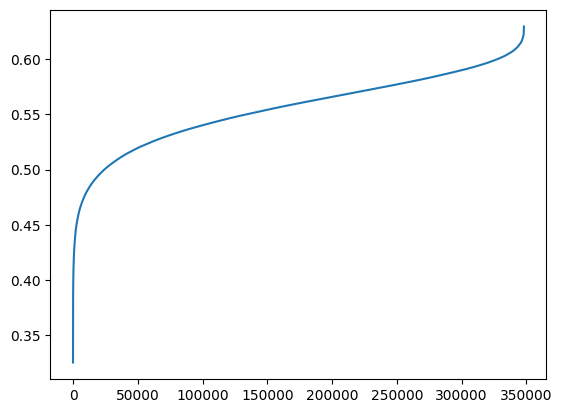

In [13]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [ ]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

24184

In [15]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,race_prestige,mean_cyclist_cp,mean_delta,mean_position,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,isolation_forest_degree,isolation_forest_scores
count,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184,...,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.000000,24184.0
mean,1983.495452,69.698400,180.670112,159.570170,239.026257,183.050208,2.846072,2.915399,1131.174826,2013-09-13 03:45:47.337082112,...,0.278702,0.015558,483.433277,0.474376,0.474987,478.513051,0.021889,0.337294,0.476796,1.0
min,1963.000000,48.000000,158.000000,20.000000,6.000000,1.150000,0.002000,1.000000,156.000000,2001-03-03 00:00:00,...,0.000000,0.000009,38.142857,0.086467,0.008065,0.000000,0.000003,0.000185,0.325102,1.0
25%,1978.000000,64.000000,175.000000,80.000000,20.000000,157.000000,1.380000,2.000000,861.000000,2009-04-05 00:00:00,...,0.109094,0.002087,256.294227,0.331442,0.331256,230.624482,0.001920,0.086854,0.467269,1.0
50%,1983.000000,70.000000,181.000000,100.000000,120.000000,201.600000,2.863000,2.000000,1058.000000,2013-07-19 00:00:00,...,0.264701,0.005529,458.608407,0.485015,0.482123,422.894104,0.004905,0.271899,0.483002,1.0
75%,1989.000000,75.000000,186.000000,275.000000,500.000000,254.800000,4.208000,5.000000,1489.000000,2018-07-18 00:00:00,...,0.387184,0.018076,638.826869,0.600292,0.602333,603.854656,0.022067,0.533188,0.492765,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.908128,0.107286,7291.800000,0.988328,0.995968,13027.500000,0.486024,1.000000,0.499999,1.0
std,7.982607,7.700316,7.287925,103.092178,239.104026,84.962791,1.691791,1.548308,355.602986,NaN,...,0.190541,0.022194,306.932668,0.170593,0.175662,435.698530,0.040397,0.282466,0.021502,0.0


In [16]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)